In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import datetime
from geopy import distance

## Data Cleaning

In [4]:
def filter_us(df):
  return df[(df['longitude'] < -67) & (df['longitude'] > -125) & (df['latitude'] < 48) & (df['latitude'] > 25)]
def filter_speed(df):
  return df[df['speed'] < 3]
def filter_day(df):
  return df[(df['dayofweek'] != 5) & (df['dayofweek'] != 6)]

def filter_wifi(df): # deprecated in favor of filter_wifi_network
  return df[(df['wifi_ssid'] != "<unknown ssid>") & (~df['wifi_ssid'].isnull())]
def filter_wifi_network(df):
  return df[df['network'] == "wifi"]
def filter_horizontal_accuracy(df):
  return df[df['horizontal_accuracy'] < 200]


'''time filtering for median method'''
def filter_home(df):
  new_df = df.set_index('location_at').between_time('21:00', '23:59').reset_index()
  new_df = df.set_index('location_at').between_time('00:00', '5:00').reset_index().append(new_df)
  return filter_wifi(df)
def filter_work(df):
  return df.set_index('location_at').between_time('9:00', '17:00').reset_index()

In [5]:
'''67, 85, 98, 115, 125'''

def adjust_timezones(df):
  def determine_time(col):
    if col['longitude'] > -85:
      return col['location_at'] - datetime.timedelta(hours=8)
    elif col['longitude'] <= -85 and col['longitude'] > -98:
      return col['location_at'] - datetime.timedelta(hours=7)
    elif col['longitude'] <= -98 and col['longitude'] > -115:
      return col['location_at'] - datetime.timedelta(hours=6)
    else:
      return col['location_at'] - datetime.timedelta(hours=5)
    
  df['location_at'] = df.apply(determine_time, axis=1).values

In [6]:
def clean_data(df):
  df['location_at'] = pd.to_datetime(df['location_at'])
  adjust_timezones(df)
  df['dayofweek'] = df['location_at'].apply(lambda x: x.weekday())
  df = filter_day(df)
  df = filter_us(df)
  df = filter_speed(df)
  df = filter_horizontal_accuracy(df)
  
  '''
  print(len(df))
  df = filter_wifi_network(df)
  print(len(df))
  '''
  
  return df

In [ ]:
android1 = pd.read_csv("C408AA4C-197E-496F-B75D-138E8A849254.csv", names=["app_id", "ad_id", 'platform', 'latitude', 'longitude', 'horizontal_accuracy', 'location_at', 'email', 'ipv_4', 'user_agent', 'country', 'battery', 'background', 'network', 'venue_name', 'venue_category', 'vertical_accuracy', 'speed', 'heading', 'publisher_id', 'dwell_time', 'person_id', 'client_id', 'sdk_version', 'altitude', 'ipv_6', 'mobile_number', 'captured_at', 'created_at', 'floor', 'carrier', 'manufacturer', 'device_model', 'wifi_ssid', 'wifi_bssid', 'decorated_at', 'dist_moved', 'day_number', 'day_type', 'time_type', 'dwell_type', 'confidence', 'brand_name', 'source', 'tech_signals', 'geo_country', 'misc'])
android1 = clean_data(android1)
#ios1 = pd.read_csv("C5C055AE-9492-44E2-9915-ADBD6DAAE765.csv", names=["app_id", "ad_id", 'platform', 'latitude', 'longitude', 'horizontal_accuracy', 'location_at', 'email', 'ipv_4', 'user_agent', 'country', 'battery', 'background', 'network', 'venue_name', 'venue_category', 'vertical_accuracy', 'speed', 'heading', 'publisher_id', 'dwell_time', 'person_id', 'client_id', 'sdk_version', 'altitude', 'ipv_6', 'mobile_number', 'captured_at', 'created_at', 'floor', 'carrier', 'manufacturer', 'device_model', 'wifi_ssid', 'wifi_bssid', 'decorated_at', 'dist_moved', 'day_number', 'day_type', 'time_type', 'dwell_type', 'confidence', 'brand_name', 'source', 'tech_signals', 'geo_country', 'misc'])

## Median Method

In [0]:
def centroid_method_median(df):
  return df['latitude'].median(), df['longitude'].median()

In [0]:
work_android = filter_work(android1)
home_android = filter_home(android1)
print(len(work_android))
print(len(home_android))

print(centroid_method_median(work_android))
print(centroid_method_median(home_android))

We've found it it is hard to determine someone's work and home based on time of day - thus, the simple median of the points will not work

## KMeans Method

procedure:
1. run kmeans
2. filter outliers
3. run kmeans on the same number of clusters
4. check distance, increase clusters and rerun procedure as needed

In [0]:
def run_kmeans(df, num_clusters):
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(df[['latitude', 'longitude']])
  df['kmeans_labels'] = kmeans.labels_
  df['centroids'] = df['kmeans_labels'].apply(lambda x: kmeans.cluster_centers_[x])
  return df, kmeans

In [0]:
def filter_ok_group(df, num_clusters):
  ''' filters the outliers of a kmeans dataframe, rerun kmeans, and then check if there are points greater than 200 meters from the centroids '''
  
  find_max_dist(df) # this method call is to append the 'dist_from_centroid' column to the df
  # filter outliers
  kmeans_groups = df.groupby('kmeans_labels')
  new_df = pd.DataFrame()
  for name, group in kmeans_groups:
    filtered = filter_dist_outliers(group)
    new_df = new_df.append(filtered)
    
  # run kmeans on the filtered data
  new_df, kmeans = run_kmeans(new_df, num_clusters)
  
  # filter out points greater than 200 meters from centroids
  DIST_THRESHOLD = 200 # meters
  kmeans_groups = new_df.groupby('kmeans_labels')
  group = kmeans_groups.get_group(kmeans_groups.size().index[0]) # largest group
  
  max_dist = find_max_dist(group)
  if max_dist > DIST_THRESHOLD:
    return new_df, False
  else:
    return new_df, True

  
def find_max_dist(df):
  ''' returns the max distance between points in a list '''
  lats = df['latitude'].values
  lons = df['longitude'].values
  centroid = df['centroids'].values[0]

  max_dist = 0
  dists = []
  for i in range(len(lats)):
    dist = distance.distance((lats[i], lons[i]), centroid).m
    dists.append(dist)
    if dist > max_dist:
      max_dist = dist
  df['dist_from_centroid'] = dists
  return max_dist

def filter_dist_outliers(df):
  ''' filters distances from the centroid'''
  
  q3 = df["dist_from_centroid"].quantile(0.75)
  q1 = df["dist_from_centroid"].quantile(0.25)
  IQR = q3 - q1
  upper_outlier_bound = q3 + 1.5 * IQR
  return df[df['dist_from_centroid'] < upper_outlier_bound]

In [0]:
def iterate_kmeans(df):
  kmeans_df, kmeans_object = run_kmeans(df, 2)
  kmeans_df, boo = filter_ok_group(kmeans_df, 2)
  
  c = 3
  while not boo:
    kmeans_df, kmeans_object = run_kmeans(kmeans_df, c)
    kmeans_df, boo = filter_ok_group(kmeans_df, c)
    c += 1
    
  plt.scatter(kmeans_df['longitude'], kmeans_df['latitude'], c=kmeans_df['kmeans_labels'], cmap='PRGn')
  
  centroids = kmeans_df['kmeans_labels'].value_counts().index
  print(kmeans_df['kmeans_labels'].value_counts())
  for centroid in centroids:
    print(kmeans_object.cluster_centers_[centroid])
  return kmeans_object.cluster_centers_[centroids[0]], kmeans_object.cluster_centers_[centroids[1]] # home, work

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1    4160
0    3523
3      42
2      22
Name: kmeans_labels, dtype: int64
[ 39.04749916 -94.36747007]
[ 38.97879526 -94.36500111]
[ 38.98689342 -94.34943188]
[ 39.00112229 -94.35635764]


(array([ 39.04749916, -94.36747007]), array([ 38.97879526, -94.36500111]))

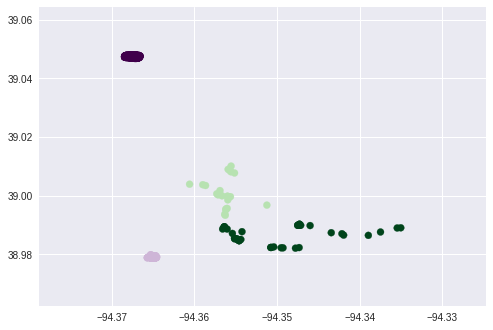

In [81]:
iterate_kmeans(android1)

# Scatter Plots

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def graph_device(df_all, df_filter, home_centroid, work_centroid, home_median, work_median):
    print(len(df_all.index), len(df_filter.index))
    x1 = df_all['longitude'] 
    y1 = df_all['latitude']
    x2 = df_filter['longitude']
    y2 = df_filter['latitude']
    x3 = home_centroid[1]
    y3 = home_centroid[0]
    x4 = work_centroid[1]
    y4 = work_centroid[0]
    x5 = home_median[1]
    y5 = home_median[0]
    x6 = work_median[1]
    y6 = work_median[0]
    plt.figure(figsize=(15, 15))
    plt.scatter(x1, y1, s=1, color='lightblue', marker="o", label='df_all')
    plt.scatter(x2, y2, s=1, color='blue', marker="o", label='df_filter')
    plt.scatter(x3, y3, s=1, color='orange', marker="o", label='home_centroid')
    plt.scatter(x4, y4, s=1, color='orange', marker="s", label='work_centroid')
    plt.scatter(x5, y5, s=1, color='yellow', marker="o", label='home_median')
    plt.scatter(x6, y6, s=1, color='yellow', marker="s", label='work_median')
    xmax = x2.max()
    xmin = x2.min()
    plt.xlim(xmax, xmin)
    ymax = y2.max()
    ymin = y2.min()
    plt.ylim(ymax, ymin)
    plt.xlabel("longitude")
    plt.ylabel("latitude")
    plt.legend()
    plt.show()